

In this second exercise, we will learn a probabilisitc generative model for the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). 


In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

Unlike the localization example, we will train both the **generative model parameters** and the parameters of the **inference variaitonal family**.

----

<img src="genmodel.png" style="width: 800px;">


---

----

<img src="infermodel.png" style="width: 800px;">

## ELBO lower-bound to $p(\mathbf{X})$

<img src="ELBO.png" style="width: 800px;">

Where $\text{KL}(q_{\eta,\mathbf{x}}(\mathbf{z})||p(\mathbf{z}))$ is known in closed form since it is the KL divergence between two Gaussian pdfs:

\begin{align}
\text{KL}(q_{\eta,\mathbf{x}}(\mathbf{z})||p(\mathbf{z})) = \frac{1}{2} \left[\text{tr}\left(\text{diag}(\sigma_{\eta}(\mathbf{x}))\right)+\left(\mu_{\eta}(\mathbf{x})^T\mu_{\eta}(\mathbf{x})\right)-2-\log\det \left(\text{diag}(\sigma_{\eta}(\mathbf{x}))\right) \right]
\end{align}

## SGD optimization

- Sample a M-size minibatch of images.
- Sample $\mathbf{\epsilon}^{(i)}$ from $\mathcal{N}(\mathbf{0},\mathbf{I})$, $i=1,\ldots,M$.
- For $i=1,\ldots,M$, compute
\begin{align}
\mathbf{z}^{(i)} = \mu_\eta(\mathbf{x}^{(i)}) + \sqrt{\text{diag}(\sigma_\eta(\mathbf{x}^{(i)}))} \circ \mathbf{\epsilon}^{(i)}
\end{align}
- Compute gradients of 
\begin{align}
\hat{\mathcal{L}}(\mathbf{X},\theta,\eta) =\sum_{i=1}^M \Big(\log  p_\theta(\mathbf{x}^{(i)}|\mathbf{z}^{(i)}) - \text{KL}(q_{\eta,\mathbf{x}^{(i)}}(\mathbf{z})||p(\mathbf{z}))\Big)
\end{align}
w.r.t. $\theta,\eta$
- Perform SGD update




In [ ]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# use seaborn plotting defaults
import seaborn as sns; sns.set()

First off, let's load the dataset through torchvision.

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

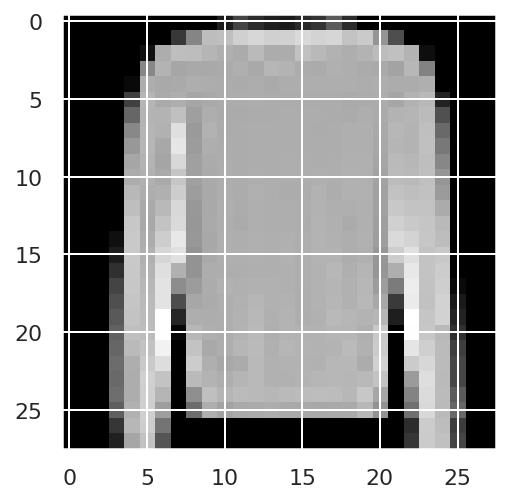

In [ ]:
image, label = next(iter(trainloader))
plt.imshow(image[20,:].numpy().reshape([28,28]),cmap='gray')

### Probabilistic model definition and generating samples

We assume that all parameteres in the probabilistic model are known. To generate the sample matrix $\mathbf{X}$, we fix the target position. Our goal is to run the inference method to estimate the target position exclusively from $\mathbf{X}$.

### Steps 1 & 2: 

#### Defintion of the NN that define the generative model (decoder)

Given $\mathbf{z}\sim\mathcal{N}(0,I)$, we will train **one** NN to estimate the mean of $p(\mathbf{x}|\mathbf{z})$. 
The NN has two hidden layers with hiperbolic tangent activations and no activation at the output. 

For simplicity, we fix the covariance of $p(\mathbf{x}|\mathbf{z})$ to a diagonal identity matrix. But this could be trained too! 

#### Defintion of the NNs that define the posterior mean and covariance matrix

Given $\mathbf{X}$ (reshaped into a vector), we will train two NNs to estimate both the mean and covariance matrix of the approximation to the posterior $q(\mathbf{z}|\mathbf{X})$. We assume a diagonal covariance matrix. In this way, the NN provides the diagonal of the covariance matrix.

Each NN has two hidden layers with hiperbolic tangent activations and no output activation. Since the diagonal of the covariance matrix can only contain positive numbers, we assume the network outpus the **logarithm of the diagonal of the covariance matrix variance**.

We will use a common class to construct both the decoder and posterior moments.

> **Exercise:** Complete the following code


In [ ]:
class moments(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dims,train_cov=True):
        super().__init__()
        
        self.train_cov = train_cov
        
        # Inputs to hidden layer linear transformation
        self.hidden_mean = nn.Linear(input_dim,hidden_dims[0])
        
        self.hidden_mean_2 = nn.Linear(hidden_dims[0],hidden_dims[1])
        
        # Mean linear layer
        self.output_mean = nn.Linear(hidden_dims[1], output_dim)
        
        if(self.train_cov == True):
            self.hidden_var = nn.Linear(input_dim,hidden_dims[0])
        
            self.hidden_var_2 = nn.Linear(hidden_dims[0],hidden_dims[1])
            
            # Diagonal variance linear layer
            self.output_log_var = nn.Linear(hidden_dims[1], output_dim)

        self.activation = nn.Tanh()
                
        
    def forward(self, input_vector):
        # Pass the input tensor through each of our operations

        self.mean = self.activation(self.hidden_mean(input_vector))
        self.mean = self.activation(self.hidden_mean_2(self.mean))

        self.mean = self.output_mean(self.mean)
        
        if(self.train_cov == True):
            
            self.log_var = self.activation(self.hidden_var(input_vector))
            self.log_var = self.activation(self.hidden_var_2(self.log_var))
            
            self.log_var = self.output_log_var(self.log_var)

### Step 3: Create a class to evaluate the loss function (ELBO)

The following class creates the decoder and the inference networks, and evaluates the ELBO

> **Exercise:** Complete the following code


In [ ]:
class Variational_Loss():
    
    def __init__(self,z_dim,x_dim,hidden_dims_inference,hidden_dims_decoder,batch_size):
        
        self.z_dim = z_dim
        
        self.batch_size = batch_size
        
        # Create the decoder networs
        
        self.decoder = moments(z_dim,x_dim,hidden_dims_decoder,train_cov=False)
        
        # Create the inference networks (now we do train the covariance matrix network, so set train_cov=True)
        
        self.inference = moments(x_dim,z_dim,hidden_dims_inference,train_cov=True)
             
        
    def sample_from_q(self,x):
        
        self.inference.forward(x)
        
        # Sampling from q(z|x). 
        # We first sample from N(0,I)
        # Then, scale by std vector and sum the mean (they are contained in the self.inference class)
        
        noise = torch.FloatTensor(x.shape[0], self.z_dim).normal_()
        
        self.sample = self.inference.mean + torch.sqrt(torch.exp(self.inference.log_var))*noise
          
    def generative_sample(self):
        
        # Generate a batch of samples from the generative model
        
        prior_sample = torch.FloatTensor(self.batch_size, self.z_dim).normal_()
        
        self.decoder.forward(prior_sample)
    
    def ELBO(self,x):
    
        self.sample_from_q(x)
        
        # KL divergence ELBO regularizer
        
        self.KL = torch.sum(-0.5*self.z_dim+0.5*torch.sum(
                torch.exp(self.inference.log_var)+self.inference.mean**2-self.inference.log_var))
        
        # Evaluate log-likelihood for the current z sample
        # To do this we use the probabilistic model p(x|z)!

        self.decoder.forward(self.sample)
        
        output_variance = 1. #Identity covariance matrix
        
        log_lik = -0.5 * (x-self.decoder.mean)**2/output_variance
    
        self.log_lik = torch.sum(log_lik)
    
        self.ELBO_loss = -(self.log_lik - self.KL)

### Step 4: Create a class to perform ELBO optimization 

Create a new class inherited from `Variational_Loss` that implements a method to perform a SGD step over the variational bound (ELBO)

> **Exercise:** Complete the following code

In [ ]:
class VAE(Variational_Loss):
    
    def __init__(self,z_dim,x_dim,hidden_dims_inference,hidden_dims_decoder,batch_size):
        
        super().__init__(z_dim,x_dim,hidden_dims_inference,hidden_dims_decoder,batch_size)
        
        # Inference Network optimizer
        
        self.optimizer_inf = optim.Adam(self.inference.parameters(),lr=1e-4)
        
        # Decoder Network optimizer
        
        self.optimizer_dec = optim.Adam(self.decoder.parameters(),lr=1e-4)
                
        
    # One SGD 
    def SGD_step(self,x):
        
        self.optimizer_inf.zero_grad()
        
        self.optimizer_dec.zero_grad()
        
        self.ELBO(x)
        
        self.ELBO_loss.backward()
        
        self.optimizer_inf.step()
        
        self.optimizer_dec.step()
    

### Step 5: Training the inference model 

> **Exercise:** Complete the following code

In [ ]:
hidden_dims_inference = [50, 100]

hidden_dims_decoder = [100, 50]

z_dim = 2         # VERY SMALL LATENT SPACE! WE USE IT TO VISUALIZE 2-D PROYECTIONS

x_dim = 28**2

myvae = VAE(z_dim,x_dim,hidden_dims_inference,hidden_dims_decoder,64)

In [ ]:
epochs = 10

period_plot = 1

for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # SGD step
        
        myvae.SGD_step(images)
        
    if(e % period_plot == 0):
        
        print("Epoch = %d, loglik = %.5f, KL = %.5f, ELBO = %.5f" 
              %(e,myvae.log_lik,myvae.KL,myvae.ELBO_loss))

        

Epoch = 0, loglik = -2601.05151, KL = 164.58170, ELBO = 2765.63330
Epoch = 1, loglik = -2003.71814, KL = 162.02744, ELBO = 2165.74561
Epoch = 2, loglik = -2335.06689, KL = 172.82967, ELBO = 2507.89648
Epoch = 3, loglik = -1857.24121, KL = 170.09337, ELBO = 2027.33459
Epoch = 4, loglik = -1702.17822, KL = 179.59308, ELBO = 1881.77124
Epoch = 5, loglik = -2144.23291, KL = 183.58029, ELBO = 2327.81323
Epoch = 6, loglik = -1941.32129, KL = 183.06221, ELBO = 2124.38354
Epoch = 7, loglik = -1921.48804, KL = 189.59775, ELBO = 2111.08569
Epoch = 8, loglik = -1840.09875, KL = 183.88110, ELBO = 2023.97986
Epoch = 9, loglik = -1949.17505, KL = 187.16676, ELBO = 2136.34180


### Step 6: plot some images and their reconstruction

For a given image $\mathbf{x}$, take the mean $\tilde{\mathbf{z}}$ of $q(\mathbf{z}|\mathbf{x})$ and use it as input to the decoder network. The following code compares both $\mathbf{x}$ and the mean of $p(\mathbf{x}|\tilde{\mathbf{z}})$.

> **Exercise:** Complete the following code

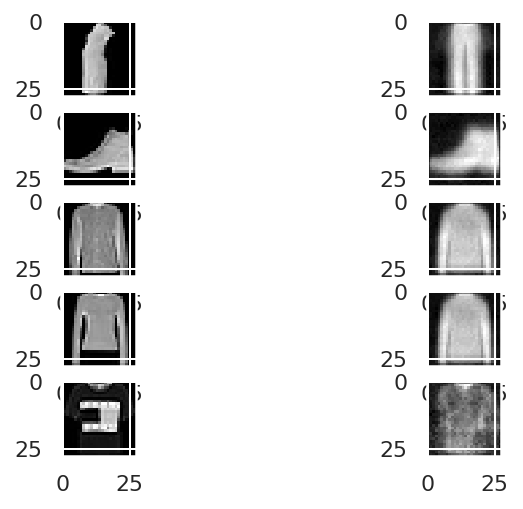

In [ ]:
n_plots_axis=5

f2, axarr2 = plt.subplots(n_plots_axis,2)

images, label = next(iter(trainloader))
images = images.view(images.shape[0], -1)

myvae.inference.forward(images)
myvae.decoder.forward(myvae.inference.mean)

for i in range(n_plots_axis):

    axarr2[i,0].imshow(images[i,:].numpy().reshape([28,28]),cmap='gray');
    axarr2[i,1].imshow(myvae.decoder.mean[i,:].detach().numpy().reshape([28,28]),cmap='gray'); 
    

### Step 7: Latent projection of images 

The following code plots in the latent 2-D space a minibatch of train images

In [ ]:
def plot_latent_space_with_images(ax,recons_images,z_samples):
    
    ax.clear()
    for i in range(32):
        im = OffsetImage(recons_images[i].reshape([28,28]), zoom=1,cmap='gray')
        ab = AnnotationBbox(im, z_samples[i],frameon=True)
        ax.add_artist(ab)
    ax.set_xlim(np.min(z_samples[:,0])-1,np.max(z_samples[:,0])+1)
    ax.set_ylim(np.min(z_samples[:,1])-1,np.max(z_samples[:,1])+1)
    ax.set_title('Latent space Z with Images')

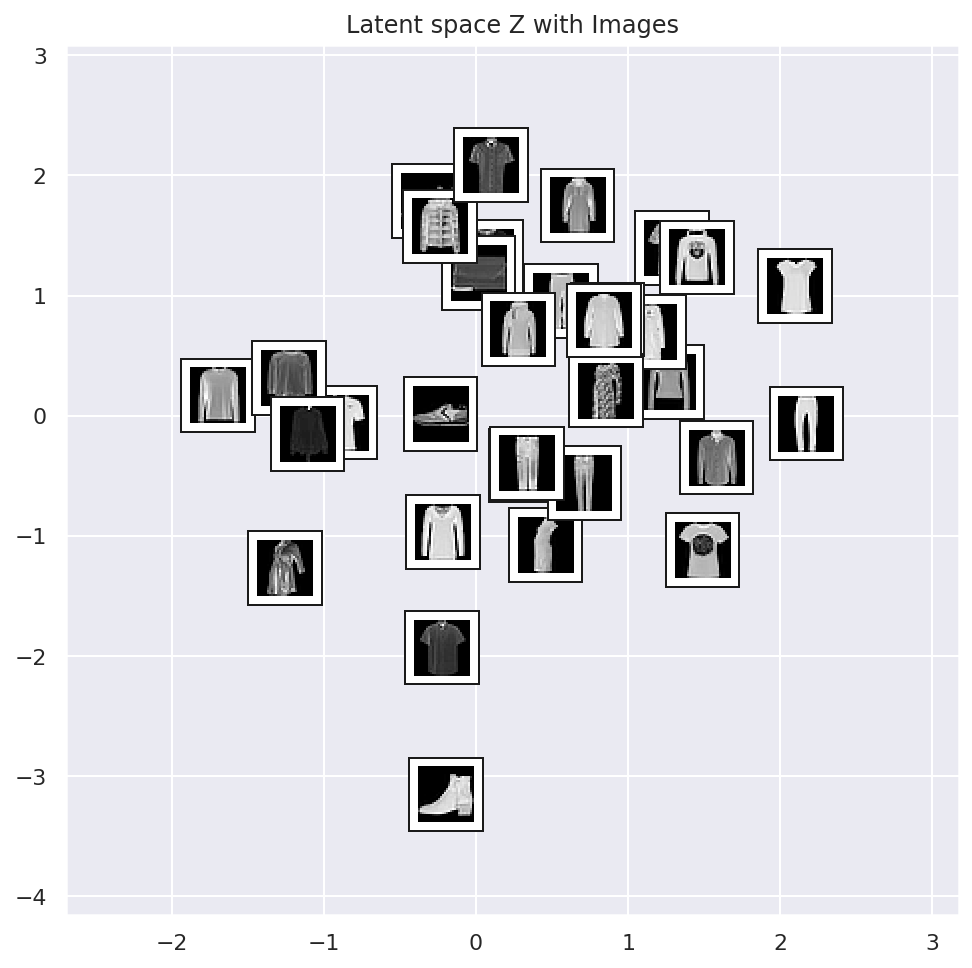

In [ ]:
f_latent, ax_latent = plt.subplots(1,1,figsize=(8, 8))
plot_latent_space_with_images(ax_latent,images,myvae.sample.detach().numpy()) 

### Step 8: Generate new images from the probabilistic model 

Use the method `generative_sample` to generate new images

> **Exercise:** Complete the following code

In [ ]:
myvae.generative_sample()

new_images = myvae.decoder.mean.detach().numpy()

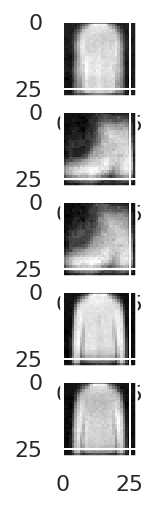

In [ ]:
n_plots_axis=5

f3, axarr3 = plt.subplots(n_plots_axis,1)

for i in range(n_plots_axis):

    axarr3[i].imshow(new_images[i,:].reshape([28,28]),cmap='gray')

### Step 9: train a new VAE with larger latent dimension and CNNs

> - Evaluate if the quality of generated images and the reconstruction quality improves if we increase the dimensionality of the latent space.
>
> - (**Optional**) Construct a new VAE that is based on both convolution/deconvolution layers

In [ ]:
vae0 = VAE(4,x_dim,hidden_dims_inference,hidden_dims_decoder,64)
vae1 = VAE(7,x_dim,hidden_dims_inference,hidden_dims_decoder,64)


t = 1
epochs = 10
for e in range(epochs):
    
    for images, labels in trainloader:
        # Flatten images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # SGD step
        
        vae0.SGD_step(images)
        vae1.SGD_step(images)


    if(e % t == 0):
        
        print("1st VAE: Epoch = %d, loglik = %.5f, KL = %.5f, ELBO = %.5f" 
              %(e,vae0.log_lik,myvae0.KL,vae0.ELBO_loss))
        print("2nd VAE: Epoch = %d, loglik = %.5f, KL = %.5f, ELBO = %.5f" 
              %(e,vae1.log_lik,myvae1.KL,vae1.ELBO_loss))
      



1st VAE: Epoch = 0, loglik = -2566.20801, KL = 554.81439, ELBO = 2815.91040
2nd VAE: Epoch = 0, loglik = -2493.69043, KL = 668.43689, ELBO = 2813.81421
1st VAE: Epoch = 1, loglik = -2500.85620, KL = 554.81439, ELBO = 2780.64917
2nd VAE: Epoch = 1, loglik = -2533.00000, KL = 668.43689, ELBO = 2863.30396
1st VAE: Epoch = 2, loglik = -1873.19189, KL = 554.81439, ELBO = 2143.11035
2nd VAE: Epoch = 2, loglik = -1866.30103, KL = 668.43689, ELBO = 2185.91821
1st VAE: Epoch = 3, loglik = -1705.30579, KL = 554.81439, ELBO = 1990.46606
2nd VAE: Epoch = 3, loglik = -1725.04175, KL = 668.43689, ELBO = 2063.72119
1st VAE: Epoch = 4, loglik = -1585.83411, KL = 554.81439, ELBO = 1875.97070
2nd VAE: Epoch = 4, loglik = -1572.57715, KL = 668.43689, ELBO = 1932.39844
1st VAE: Epoch = 5, loglik = -1648.34973, KL = 554.81439, ELBO = 1951.75989
2nd VAE: Epoch = 5, loglik = -1604.41663, KL = 668.43689, ELBO = 1988.39819
1st VAE: Epoch = 6, loglik = -1319.01868, KL = 554.81439, ELBO = 1608.02795
2nd VAE: Epo

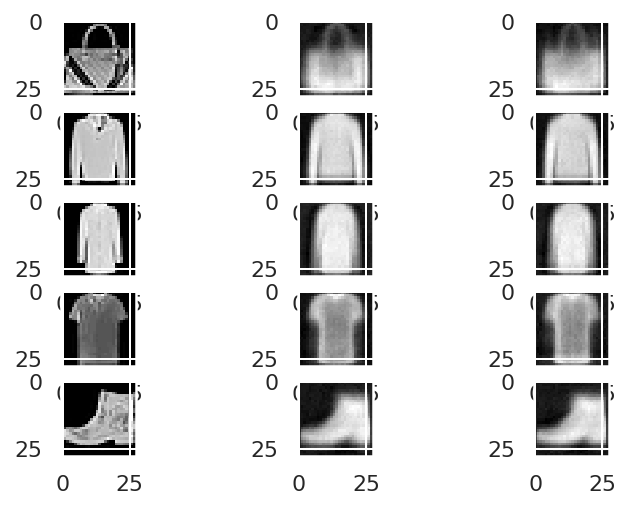

In [ ]:


f, ax = plt.subplots(5,3)

images, label = next(iter(trainloader))
images = images.view(images.shape[0], -1)

vae0.inference.forward(images)
vae0.decoder.forward(vae0.inference.mean)

vae1.inference.forward(images)
vae1.decoder.forward(vae1.inference.mean)

for i in range(n_plots_axis):

    ax[i,0].imshow(images[i,:].numpy().reshape([28,28]),cmap='gray');
    ax[i,1].imshow(vae0.decoder.mean[i,:].detach().numpy().reshape([28,28]),cmap='gray');
    ax[i,2].imshow(vae1.decoder.mean[i,:].detach().numpy().reshape([28,28]),cmap='gray');


CONCLUSION: by increasing the dimensionality of the latent space, the distorsion decreases (so the quality increases)
